<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

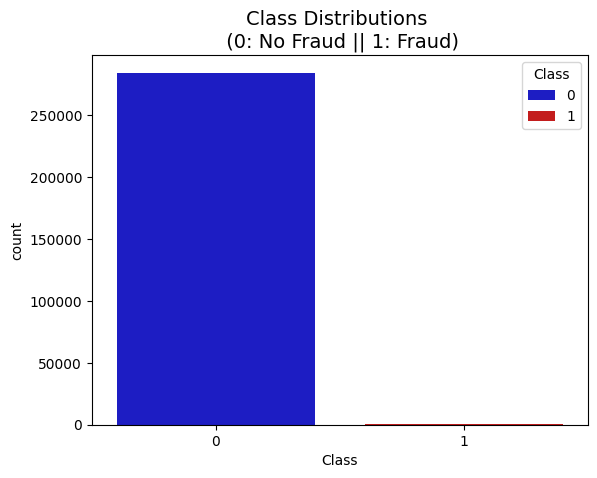

Training Logistic Regression...
Logistic Regression training completed in 12.57 seconds.
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     56750
           1       0.99      0.97      0.98     56976

    accuracy                           0.98    113726
   macro avg       0.98      0.98      0.98    113726
weighted avg       0.98      0.98      0.98    113726

ROC-AUC Score: 1.00

Training Random Forest...
Random Forest training completed in 293.30 seconds.
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     56750
           1       1.00      0.99      0.99     56976

    accuracy                           0.99    113726
   macro avg       0.99      0.99      0.99    113726
weighted avg       0.99      0.99      0.99    113726

ROC-AUC Score: 1.00

Training Neural Network...
Neural Network trainin

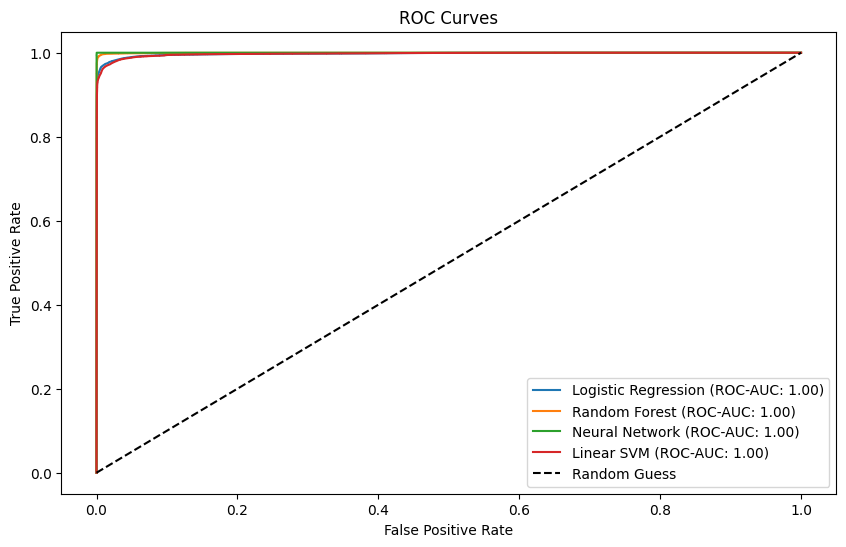

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import time
# Load the dataset
data = pd.read_csv(r'C:\Users\S4 User\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3\creditcard.csv')
# Data summary
print(data.info())
print(data.describe())
# Class distribution visualization
sns.countplot(x='Class', data=data, palette=["#0101DF", "#DF0101"], hue='Class')
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()
# Feature scaling
scaler = StandardScaler()
data['Amount'] = scaler.fit_transform(data[['Amount']])
# Splitting data into features and target
X = data.drop(columns=['Class'], axis=1)
y = data['Class']
# Addressing class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scaling the data (important for SVM and other models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(50, 50), max_iter=1000, random_state=42)
}

# Adding LinearSVC with calibrated probabilities
linear_svm = LinearSVC(C=1.0, max_iter=1000, random_state=42)
calibrated_svm = CalibratedClassifierCV(linear_svm, method="sigmoid")
models["Linear SVM"] = calibrated_svm

# Training and evaluation
results = []
for name, model in models.items():
    print(f"Training {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    print(f"{name} training completed in {end_time - start_time:.2f} seconds.")
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    roc_auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print(f"ROC-AUC Score: {roc_auc:.2f}\n")
    results.append((name, roc_auc))

# Model comparison
results_df = pd.DataFrame(results, columns=["Model", "ROC-AUC"])
print(results_df)

# Visualizing the ROC curves
plt.figure(figsize=(10, 6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (ROC-AUC: {roc_auc_score(y_test, y_prob):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()
